The callback system in the fastai library allows you to execute any code at specific times in the training. This can be extremely useful if you want to

- record some parameters (for instance metrics, gradients)
- use a condition to change a parameter (for instance change the learning rate if the validation loss hasn't improved)
- make a schedule of parameters (for instance changing the probabilities of the dropout layers as the training goes)

In this notebook, I'll show how to use this to code your own callbacks.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Let's experiment on cifar10 and small networks.

In [2]:
from fastai.conv_learner import *
PATH = Path("../data/cifar10/")

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [4]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [5]:
size = 32
batch_size = 64

In [6]:
data = get_data(size,batch_size)

I've built a simple fully convolutional neural net.

In [7]:
def ConvBlock(ch_in, ch_out, ks = 3, stride=1, padding=1, re=True, bn=True):
    layers = [nn.Conv2d(ch_in,ch_out,ks,stride=stride,padding=1, bias=False)]
    if bn: layers.append(nn.BatchNorm2d(ch_out))
    if re: layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)

In [8]:
layers = [ConvBlock(3,64), 
          ConvBlock(64,64,stride=2), #size 16x16
          ConvBlock(64,128,stride=2), #size 8x8
          ConvBlock(128,256,stride=2), #size 4x4
          ConvBlock(256,10, stride=2), #size 2x2 
          nn.AdaptiveAvgPool2d(1), 
          Flatten()]
model = nn.Sequential(*layers)

In [9]:
learn = ConvLearner.from_model_data(model, data)
learn.crit = F.cross_entropy
learn.opt_fn = partial(optim.SGD, momentum=0.9)
learn.metrics = [accuracy]

In [11]:
learn.save('init') #To go back from the first model later.

So what's a callback? Let's have a look at the source code of fastai.

In [12]:
class Callback:
    def on_train_begin(self): pass
    def on_batch_begin(self): pass
    def on_phase_begin(self): pass
    def on_epoch_end(self, metrics): pass
    def on_phase_end(self): pass
    def on_batch_end(self, metrics): pass
    def on_train_end(self): pass

This is the class that doesn't seem to do anything but it's just because it's a general wrapper. Those seven functions are all called at a certain point during training. The names are self explanatory but just in case:
- on_train_begin is called at the very beginning of the training. Useful to initialize the variables.
- on_phase_begin is called at the beginning of each training phase (if you don't use the training API, there is only one phase during training). It's useful if you plan on having a different behavior during each phase.
- on_batch_begin is called before the current batch is passed through the network, it's where you will want to update training parameters.
- on_batch_end is called at the end of the batch, with the result of the loss function. It's where you will want to save data or metrics.
- on_epoch_end is called at the end of an epoch, after the validation, with the validation loss and metrics as an argument. Again, useful to save validation data, or if you want to change something before the next epoch.
- on_phase_end is called at the end of a training phase.
- on_train_end is called at the very end of the training.

Your customized callback doesn't have to implement those seven functions since the Callback class has them all, so you can code only the ones you want. Note that you can stop the training during on_batch_end or on_epoch_end by returning True, which might be useful!

Let's begin with a simple class that will record the validation losses. To see what's going on, let's use the easiest way: use the debugger to show us what this metrics object contains.

In [13]:
class SaveValidationLoss(Callback):
    def __init__(self):
        self.val_losses = []
    
    def on_epoch_end(self, metrics):
        pdb.set_trace()

First let's find a learning rate.

In [14]:
learn.lr_find(wds=1e-3)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      2.137145   2.88337    0.1061    



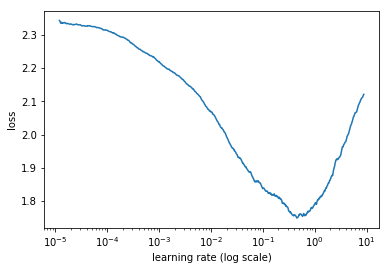

In [15]:
learn.sched.plot()

And let's get something like a 1cycle to train our network.

In [16]:
def one_cycle(lr, div, lengths, max_mom, min_mom, wds):
    return [TrainingPhase(lengths[0], optim.SGD, lr = (lr/div, lr), lr_decay=DecayType.LINEAR,
                          momentum = (max_mom,min_mom), momentum_decay=DecayType.LINEAR, wds=wds),
            TrainingPhase(lengths[1], optim.SGD, lr = (lr, lr/div), lr_decay=DecayType.LINEAR,
                          momentum = (min_mom,max_mom), momentum_decay=DecayType.LINEAR, wds=wds),
            TrainingPhase(lengths[2], optim.SGD, lr = lr/div, lr_decay=DecayType.COSINE,
                          momentum = max_mom, wds=wds)]

To use our callback in the training, we just have to add it in the arguments of fit/fit_opt_sched:

In [17]:
learn.fit_opt_sched(one_cycle(0.1, 10, [10,10,5], 0.95, 0.85, 1e-3), callbacks=[SaveValidationLoss()])

HBox(children=(IntProgress(value=0, description='Epoch', max=25), HTML(value='')))

--Return--                                                                                                             
> <ipython-input-13-9aafc4cf57fe>(6)on_epoch_end()->None
-> pdb.set_trace()
(Pdb) metrics
[1.4692460243225098, 0.4933]
(Pdb) q


BdbQuit: 

As seen in the debugger, metrics contains two elements, the first one is our validation loss, the second one is the accuracy. We can then save it and had a function plot we will be able to call later to have the graph.

In [19]:
class SaveValidationLoss(Callback):
    def on_train_begin(self):
        self.val_losses = []
    
    def on_epoch_end(self, metrics):
        self.val_losses.append(metrics[0])
    
    def plot(self):
        plt.plot(list(range(len(self.val_losses))), self.val_losses)

In [20]:
save_val = SaveValidationLoss()

In [21]:
learn.load('init')
learn.fit_opt_sched(one_cycle(0.1, 10, [10,10,5], 0.95, 0.85, 1e-3), callbacks=[save_val])

HBox(children=(IntProgress(value=0, description='Epoch', max=25), HTML(value='')))

  7%|████▋                                                                 | 52/782 [00:01<00:26, 27.80it/s, loss=2.13]


Exception in thread Thread-10:
Traceback (most recent call last):
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.321514   1.333771   0.5328    
    1      1.105817   1.150064   0.6001                                                                                
    2      1.044877   1.01592    0.6504                                                                                
    3      0.980082   1.006362   0.6439                                                                                
    4      0.958601   0.956591   0.6698                                                                                
    5      0.937474   0.927707   0.6884                                                                                
    6      0.92569    0.902543   0.6854                                                                                
    7      0.937417   0.891721   0.688                                                                              

[0.44948736786842347, 0.8513]

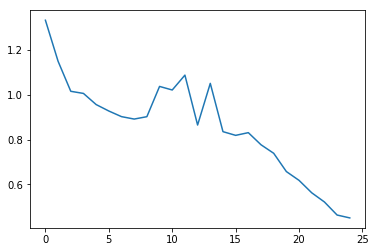

In [22]:
save_val.plot()

People often like to train a neural net with constant learning rates, dividing it automatically if the validation loss didn't progres. This is easily done with callbacks again, we just have to pass a few arguments:

- the learner object, to be able to modify its learning rate (with sched.layer_opt.set_lrs)
- the first learning rate
- the number to divide it

We can even tell the learner to stop the training through the callback by using return True. Here we specify a minimum learning rate, and once we are below it, we stop.

In [39]:
class LRScheduler(Callback):
    def __init__(self, learn, init_lr, div_lr, min_lr):
        self.learn, self.init_lr, self.div, self.min_lr = learn, init_lr, div_lr, min_lr
    
    def on_train_begin(self):
        self.first_epoch = True
        self.best_loss = 0.
        self.current_lr = self.init_lr
        self.learn.sched.layer_opt.set_lrs(self.current_lr)
    
    def on_epoch_end(self, metrics):
        val_loss = metrics[0]
        if self.first_epoch:
            self.best_loss = val_loss
            self.first_epoch = False
        elif val_loss > self.best_loss:
            self.current_lr /= self.div
            if self.current_lr < self.min_lr: return True
            else: self.learn.sched.layer_opt.set_lrs(self.current_lr)
        else: self.best_loss = val_loss

In [40]:
learn = ConvLearner.from_model_data(model, data)
learn.crit = F.cross_entropy
learn.opt_fn = partial(optim.SGD, momentum=0.9)
learn.metrics = [accuracy]

In [41]:
lr_sched = LRScheduler(learn, 0.1, 10,1e-4)

In [42]:
learn.load('init')
learn.fit(0.1, 1000, callbacks=[lr_sched]) #Big number in fit to be sure we reach the point the learner stops by itself.

HBox(children=(IntProgress(value=0, description='Epoch', max=1000), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.265199   1.222944   0.5689    
    1      1.035041   1.032537   0.6321                                                                                
    2      0.936886   0.87412    0.6865                                                                                
    3      0.866005   0.834753   0.7139                                                                                
    4      0.81119    0.730867   0.7478                                                                                
    5      0.764424   0.708939   0.7559                                                                                
    6      0.696581   0.657594   0.7718                                                                                
    7      0.69288    0.65185    0.7756                                                                             

[0.4697907167434692, 0.8398]

Note that this wasn't as efficient as a 1cycle in this situation.

Now, let's see how we can have the dropout probability change through training. We could begin with 0 and slowly increase to a maximum value. First let's add some dropout in the model (note that is just for the sake of showing how to do it since we weren't overfitting before, so dropout probably won't help much).

In [45]:
layers = [ConvBlock(3,64), 
          ConvBlock(64,64,stride=2), #size 16x16
          ConvBlock(64,128,stride=2), #size 8x8
          ConvBlock(128,256,stride=2), #size 4x4
          nn.Dropout(0.2),
          ConvBlock(256,10, stride=2), #size 2x2 
          nn.AdaptiveAvgPool2d(1), 
          Flatten()]
model = nn.Sequential(*layers)

Then we identify where it is in the model

In [46]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (4): Dropout(p=0.2)
  (5): Sequential(
    (0): Conv2d(256, 10, kernel_size=(3, 3), stride=(2,

It's the layer of index 4. We can access the p of the dropout by model[4].p

In [47]:
model[4].p

0.2

That's all we need to create our dropout scheduler! I'll use the class DecayScheduler to have something giving me the values going from 0 to the max. It's the one that's used to create the lr_decay or momentum_decay in the new training API.

It's fairly simple: you specify a decay type (linear, exponential...), a number of iterations, a min value and a max value, then you just have to call next_val each time you want to update your parameter.

In [48]:
nb_batches = len(data.trn_dl)

We need the number of batches to give our DecayScheduler the number of iterations, then we just update the p value accordingly. We have a list of schedulers, one for each phase, so we also update the index of the current phase.

In [49]:
class DropoutScheduler(Callback):
    def __init__(self, dp, scheds):
        self.dp = dp
        self.phase = 0
        self.scheds = scheds
        
    def on_train_begin(self):
        self.phase = 0
    
    def on_phase_begin(self):
        self.sched = self.scheds[self.phase]
    
    def on_phase_end(self):
        self.phase += 1
    
    def on_batch_begin(self):
        self.dp.p = self.sched.next_val()

In [51]:
dp_phases = [DecayScheduler(DecayType.LINEAR, nb_batches * 10, 0, 0.1), #first phase: go from 0 to 0.1
             DecayScheduler(DecayType.LINEAR, nb_batches * 10, 0, 0.2), #second phase: from 0.1 to 0.2
             DecayScheduler(DecayType.NO, nb_batches * 5, 0.2),] #then stay at 0.2

In [52]:
dp_sched = DropoutScheduler(learn.model[4], dp_phases)

In [53]:
learn.load('init')
learn.fit_opt_sched(one_cycle(0.1, 10, [10,10,5], 0.95, 0.85, 1e-3), callbacks=[save_val])

HBox(children=(IntProgress(value=0, description='Epoch', max=25), HTML(value='')))

 22%|███████████████                                                      | 170/782 [00:05<00:21, 28.63it/s, loss=1.86]


Exception in thread Thread-100:
Traceback (most recent call last):
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Sylvain\Anaconda3\envs\fastai\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.335023   1.206959   0.573     
    1      1.099644   1.171765   0.5953                                                                                
    2      1.063678   1.023522   0.6493                                                                                
    3      1.022308   0.922295   0.679                                                                                 
    4      0.979578   1.005916   0.6481                                                                                
    5      0.948324   0.983416   0.6652                                                                                
    6      0.924334   0.926138   0.6809                                                                                
    7      0.920498   0.915692   0.6822                                                                             

[0.4478648525238037, 0.8508]